A continuación presentamos un ejemplo de la resolución de un problema de valor inicial $\mathbf{PVI}$ asociado a una ecuacion diferencial ordinaria $\mathbf{EDO}$, mediante el uso de redes neuronales.

 Consideremos una  $\mathbf{EDO}$ de primer orden,
 $$
  \frac{d \psi (x)}{d x} =  f(x,\psi (x) ), \qquad x\in [0,1], \qquad \text{C.I.} \qquad \psi(0) A.
$$
una propuesta de solución de prueba,
$$
\psi_{t} (x;\theta) = A + x \psi(x;\theta)
$$
Encontrar una solución de la \mathbf{EDO}, equivale a encontrar los pesos $\theta$  que minimicen el error,
$$
\min_{\theta \in \mathbb{R}^{N}} \sum_{i=1}^{m}   \left ( \frac{d \psi_{t} (x_{i}; \theta  )}{d x}  - f(x_{i} , \psi_{t} (x_{i};\theta)   \right )
$$
Para ello necesitamos:
$$
\frac{d \psi (x_{i}; \theta)}{dx}, \qquad  \frac{\partial \psi_{t}(x_{i}; \theta)}{\partial \theta}.
$$

**Ejemplo de prueba 1**

Consideremos el siguiente ejemplo de prueba

$$
\frac{d^{2} \psi (x)}{dx^{2}} + \frac{1}{5} \frac{d \psi (x)}{dx} + \psi(x) = -\frac{1}{5}e^{-x/5}\cos(x), \qquad x\in [0,2]
$$
para la cual proponemos una solución de la forma,
$$\psi_{t} (x;\theta) = x +  x^{2}\psi(x;\theta).
$$
Para la cual se conoce la solución analitica,
$$
\psi^{*}(x) = e^{-x/5}sin(x)
 $$
Veamos a continuación su implementación en python.


Error: 0.7257409691810608
Error: 3.6032495498657227
Error: 0.0782570019364357
Error: 0.07734672725200653
Error: 0.07332777231931686
Error: 0.037767913192510605
Error: 0.01032843254506588
Error: 0.009638691321015358
Error: 0.007679096423089504
Error: 0.005102763883769512
Error: 0.0024885600432753563
Error: 0.00046825603931210935
Error: 9.185053204419091e-05
Error: 0.00019330171926412731
Error: 8.003726543392986e-05
Error: 7.894412556197494e-05
Error: 7.874941366026178e-05
Error: 7.788179937051609e-05
Error: 7.336986891459674e-05
Error: 2.730919914029073e-05
Error: 2.0345874872873537e-05
Error: 1.5499301298405044e-05
Error: 1.6383652109652758e-05
Error: 1.3065578059467953e-05
Error: 1.1801417713286355e-05
Error: 1.1438985893619247e-05
Error: 1.1416742381697986e-05
Error: 1.141458960773889e-05


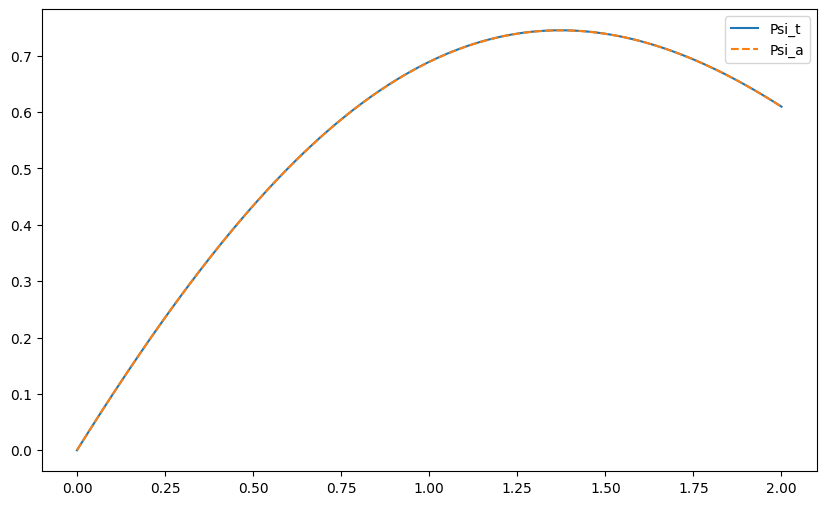

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict

def f(x):
    return -1/5 * np.exp(-x/5) * np.cos(x)

def Psi_t(x, psi, A_1=0, A_2=1):
    return A_1 + A_2*x + x**2*psi(x)

class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()

        self.L = len(n) - 1
        self.actfun = nn.Sigmoid

        layers = list()
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))
            layers.append((f'actfun_{i+1}', self.actfun()))

        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

psi = DNN(n=[1, 10, 1])
max_iters = 100

x = torch.linspace(start=0, end=2, steps=100, requires_grad=True).view(-1, 1)
with torch.no_grad():
    f_x = f(x)

criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(psi.parameters(), lr=1.0, max_iter=max_iters, line_search_fn='strong_wolfe')

def G(x, psi, criterion):
    Psi_t_ = Psi_t(x, psi)
    Psi_t_x = torch.autograd.grad(Psi_t_, x, grad_outputs=torch.ones_like(Psi_t_), retain_graph=True, create_graph=True)[0]
    Psi_t_xx = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x), retain_graph=True, create_graph=True)[0]

    return criterion(Psi_t_xx + Psi_t_x/5 + Psi_t_, f_x)

def one_step():
    # Limpiar derivadas
    optimizer.zero_grad()
    # Forward
    Error = G(x, psi, criterion)
    # Backward
    Error.backward()

    print(f'Error: {Error.item()}')

    return Error

def Run_training(x, optimizer):
    psi.train()
    # Usar una función lambda para pasar one_step sin argumentos
    optimizer.step(lambda: one_step())

Run_training(x, optimizer)

def Psi_a(x):
    return np.exp(-x/5)*np.sin(x)

x_np = x.detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_np, Psi_t(x, psi).detach().numpy(), label='Psi_t')
plt.plot(x_np, Psi_a(x_np), '--', label='Psi_a')  # Corregido para usar x_np en lugar de x
plt.legend()
plt.show()


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


Ejemplo de Ben Moseley: Oscilador Armonico



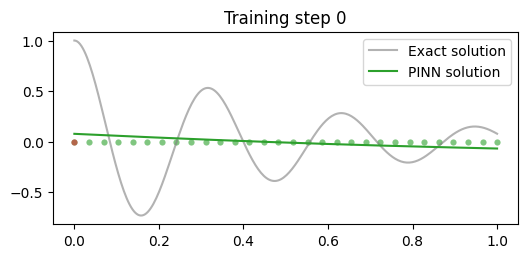

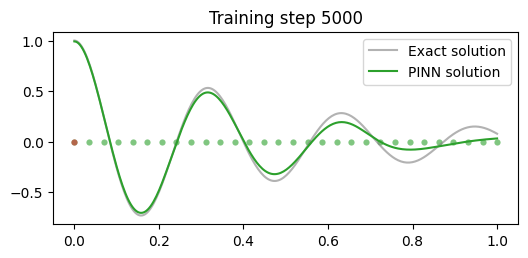

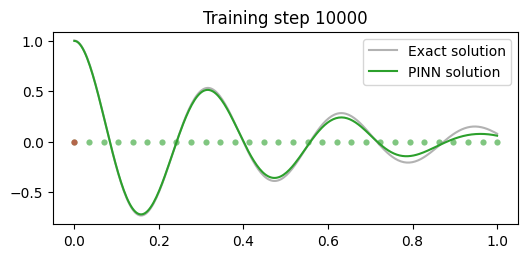

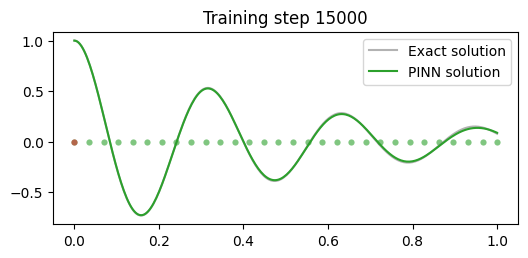

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()